### Inventory Simulation
#### INF1036 - 3WA

Fernando Homem, Júlia Aleixo, Pedro Moraes, Rafael Rubim

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats
from ipywidgets import FloatProgress
from IPython.display import display

%matplotlib inline

#### Variable declarations

In [2]:
T = 6.0
S = 15 # maximum on-hand inventory
s = 5 # minimum on-hand inventory
x0 = 15 # initial amount of inventory
r = 50 # price per product unit
L = 2 # units of time before order arrives
h = 2 # inventory holding cost
ratemax = 10 # maximum number of customers per time unit
receiveAfterClose = True # orders can arrive after store closes
hUntilClose = True # inventory holding cost is charged until store closes
costPerUnit = 10

#### Cost function
Defines the cost of ordering y units of the product.

In [3]:
def cost(y): 
    return y * costPerUnit

#### Customer's arrivals
Customers demanding the product appear in accordance with a non-homogenous Poisson process with rate λ.

In [4]:
def rate(t):
    if (t < 1.0):
        return 10.0
    elif (t < 2.0):
        return 5.0
    elif (t < 3.0):
        return 10.0
    elif (t < 4.0):
        return 2.0
    elif (t < 5.0):
        return 5.0
    else:
        return 10.0

In [5]:
def exponential(nsamples,rate):
    x = np.zeros(nsamples)
    u = np.random.sample(nsamples)
    for i in range(nsamples):
        x[i] = - math.log(1.0 - u[i]) / rate
    return x

In [6]:
def nextArrival(t,rate,ratemax):
    while(1):
        Z = exponential(1,ratemax)[0]
        t = t + Z
        U = np.random.sample(1)
        if U < rate(t) / ratemax:
            return t

#### Inventory Model
Returns the average profit per unit of time.

In [7]:
def inventory(G,T,S,s,c,x0,r,L,h,rate,ratemax,receiveAfterClose,hUntilClose):
    
    C = 0.0 # total amount of ordering costs
    R = 0.0 # total amount of revenue earned
    H = 0.0 # total amount of inventory holding costs
    x = x0 # amount of inventory
    y = 0 # amount on order
    t = 0.0 
    t0 = nextArrival(t,rate,ratemax) # arrival time of next customer
    t1 = 1.0e+30 # time of order delivery
    T0 = []
    T1 = []
    
    while(1):
        
        # customer arrives before delivery
        if t0 < t1 and t0 <= T:
            H = H + (t0 - t) * x * h
            t = t0
            T0.append(t0)
            D = G(1,rate(t))[0] # customer's demand
            w = min(D,x) # amount of the order that can be filled
            R = R + w * r
            x = x - w
            # ordering policy 
            if x < s and y == 0:
                y = S - x
                t1 = t + L
            t0 = nextArrival(t,rate,ratemax)
            
        # order arrives before next customer
        elif (t1 <= t0 or t0 > T) and t1 <= T:
            H = H + (t1 - t) * x * h
            t = t1
            T1.append(t1)
            C = C + c(y)
            x = x + y
            y = 0
            t1 = 1.0e+30
            
        else:
            # store closes and there is still an outstanding order
            if y > 0 and receiveAfterClose:
                H = H + (t1 - t) * x * h
                t = t1
                T1.append(t1)
                C = C + c(y)
                x = x + y
                y = 0
                
            elif hUntilClose:
                H = H + (T - t) * x * h
                
            totalProfit = R - C - H
            profitPerUnit = totalProfit / T # profit per unit of time
            return totalProfit, profitPerUnit, T0, T1

In [8]:
totalProfit,profitPerUnit,T0,T1 = inventory(exponential,T,S,s,cost,x0,r,L,h,rate,ratemax,receiveAfterClose,hUntilClose)
print("Total Profit: " + str(totalProfit))
print("Profit per unit of time: " + str(profitPerUnit))
print("Customer arrival times: " + str(T0))
print("Order arrival times: " + str(T1))

Total Profit: 155.43576835784935
Profit per unit of time: 25.90596139297489
Customer arrival times: [0.0031260098992682943, 0.01674242460283084, 0.1999229769279506, 0.4489961014121008, 0.5360637203100231, 0.5826270536202821, 0.687717154230904, 0.7660781841997385, 0.8108660582634647, 0.8831186136123369, 0.9786966327824783, 1.066788466222573, 1.1516004002314117, 1.2415530796572358, 1.4798267338174702, 1.5703231498711239, 1.6763976353048773, 1.8596379954441984, 2.558531991539712, 2.5950853248059205, 2.6096208337363107, 2.6917122779761806, 2.7008390994637304, 2.797784335663907, 2.8825564935927175, 2.923610214269116, 2.9734223866323743, 3.532638228865062, 4.42161567289711, 4.60595046956346, 4.795911105805576, 5.01589129209217, 5.035953681458469, 5.188859226457395, 5.202103292339735, 5.344795145055566, 5.394069972247919, 5.545663060739169, 5.621224752929744, 5.642832511471757, 5.7719723613925265, 5.847582824813852]
Order arrival times: []


#### Tests

In [9]:
def inventoryTolerance(tol,alpha):
    x = np.zeros(100)
    for i in range(100):
        totalProfit,profitPerUnit,T0,T1 = inventory(exponential,T,S,s,cost,x0,r,L,h,rate,ratemax,receiveAfterClose,hUntilClose)
        x[i] = profitPerUnit
    n  = 100
    m  = np.mean(x)
    s2 = np.var(x)
    zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
    while(2.0 * (s2 / n) * zab2 * zab2 > tol**2):
        totalProfit,nx,T0,T1 = inventory(exponential,T,S,s,cost,x0,r,L,h,rate,ratemax,receiveAfterClose,hUntilClose)
        nm  = m + (nx - m) / (n + 1)
        ns2 = (1.0 - 1.0 / n) * s2 + (n + 1.0) * (nm - m)**2
        n = n + 1
        m  = nm
        s2 = ns2 
        x = np.append(x,nx)
    return m,s2,n,x

In [10]:
tol = 0.1
alpha = 0.05

m,s2,n,x = inventoryTolerance(tol,alpha)
print("Average profit per unit of time: " + str(m))
print(s2)
print("Number of necessary scenarios: " + str(n))
zab2 = scipy.stats.norm.ppf(1.0 - alpha / 2.0)
print("The average is in the interval [" + str(m - math.sqrt(s2 / n) * zab2) + "," + str(m + math.sqrt(s2 / n) * zab2) \
      + "] with a probability of " + str(1.0 - alpha) + ".")

Average profit per unit of time: 25.80217365306805
189.39841564041797
Number of necessary scenarios: 145515
The average is in the interval [25.731463401873423,25.872883904262675] with a probability of 0.95.


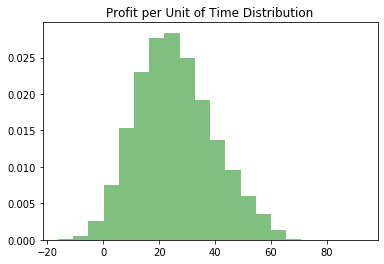

In [11]:
plt.hist(x, 20, density = 1, facecolor ='green', alpha = 0.5)
plt.title("Profit per Unit of Time Distribution")
plt.show()

#### Ordering Policy

By varying the values of S and s, we are able to determine the ordering policy that maximizes the store's profits.

In [13]:
f = FloatProgress(min = 0, max = 225)
display(f)
f.description = "Loading"

maximum_profit = -1.0e+30
best_S = 0
best_s = 0

for S in range(25,40):
    for s in range(25,10,-1):
        m,s2,n,x = inventoryTolerance(tol,alpha)
        if m > maximum_profit:
            maximum_profit = m
            best_S = S
            best_s = s
        f.value = f.value + 1
            
print("Maximum profit: " + str(maximum_profit))
print("Best ordering policy (s,S): (" + str(best_s) + "," + str(best_S) + ")")

FloatProgress(value=0.0, max=225.0)

Maximum profit: 1.0824352892560067
Best ordering policy (s,S): (11,25)
